In [8]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

# Data processing
import numpy as np
import scipy as sp
import pandas as pd
import math
from scipy import stats
import joblib


# System 
#from __future__ import print_function
import time
import os
import re
import random
import datetime
import json


# Learning & Extraction
from sklearn.decomposition import NMF
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import re
import string

from sklearn.feature_extraction import text
import langid
from topia.termextract import tag
from topia.termextract import extract

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('vader_lexicon')
nltk.download('averaged_perceptron_tagger')

regex = re.compile('[%s]' % re.escape(string.punctuation))


# Dimensionality Reduction & Distances
from sklearn.metrics.pairwise import cosine_similarity
from scipy.cluster.hierarchy import ward, dendrogram

#Plotting
import matplotlib.pyplot as plt


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/marcogarieri/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/marcogarieri/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/marcogarieri/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/marcogarieri/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [20]:
######
# Utility Functions
######
### Data Preprocessing
def remove_numericals(s):
    s = "".join([c for c in s if not c.isdigit()])
    return s

def remove_punctuation(s):
    s2 = ''
    for c in s:
        if c not in string.punctuation:
            s2 = s2 + c
        else:
            s2 = s2 + ' '
    return s2

def remove_propers_POS(s):
    tagged = nltk.pos_tag(s.split()) #use NLTK's part of speech tagger
    non_propernouns = [word for word,pos in tagged if pos != 'NNP' and pos != 'NNPS']
    return ''.join([n + " " for n in non_propernouns])

### Tokenizers

def tokenizer(s):
    return nltk.word_tokenize(s)

stemmer = nltk.stem.porter.PorterStemmer()

def stem_tokens(tokens):
    return [stemmer.stem(item) for item in tokens]

def stem_tokenizer(s):
    return stem_tokens(nltk.word_tokenize(s))

os.chdir(os.getcwd())

def safe_detect(x):
    try:
        return(langid.classify(x))[0]
    except:
        print x
        return(None)

def preprocessor(s):
    s = remove_propers_POS(s)
    # remove numericals
    # remove punctuation
    s = "".join([c if c not in string.punctuation else ' ' for c in s if not c.isdigit()])
    s = s.lower()
    #s = spell_check(s)
    return s


In [5]:

version = "_27_07_2016"
with open('amis_articles{0}.jsonl'.format(version)) as f:
    articles = pd.DataFrame(json.loads(line) for line in f)

articles['date'] = pd.to_datetime(articles['date'])
articles['timestamp'] = articles['date'].apply(lambda d: time.mktime(d.timetuple()))
articles = articles.sort('date', ascending=1)

articles['raw_article'] = articles['article'] 

sources = list(articles['source'].unique())


In [17]:
n_topics = 50
n_words = 20
n_features = 10000

In [18]:
articles.count()

article        129563
date           129563
link           129563
source         129563
title          129563
timestamp      129563
raw_article    129563
dtype: int64

In [8]:
articles['article'] = articles['raw_article'].apply(lambda x: preprocessor(x.decode('utf-8')))
# if s is not np.nan and s != ''

In [21]:
tf_vectorizer = text.CountVectorizer(max_df=.95, min_df=2, ngram_range=(1, 1),
                                        max_features=n_features, tokenizer=tokenizer,
                                        stop_words=list(text.ENGLISH_STOP_WORDS))
tf = tf_vectorizer.fit_transform(articles['article'])
tf_feature_names = tf_vectorizer.get_feature_names()


In [23]:
tf_freqs = [(word, tf.getcol(idx).sum()) for word, idx in tf_vectorizer.vocabulary_.items()]
tf_freqs = pd.DataFrame(tf_freqs, columns=('word', 'freq'))

In [24]:
tf_freqs.head()

,word,freq
0,bringing,4964
1,provide,17566
2,wednesday,278
3,affiliates,310
4,affiliated,1138


In [25]:
%store articles
%store tf_vectorizer
%store tf
%store tf_freqs

Stored 'articles' (DataFrame)
Stored 'tf_vectorizer' (CountVectorizer)
Stored 'tf' (csr_matrix)
Stored 'tf_freqs' (DataFrame)


## Non-negative Matrix Factorization

In [26]:
%store

Stored variables and their in-db values:
articles                  ->                                                   
tf                        -> <129563x10000 sparse matrix of type '<type 'numpy.
tf_freqs                  ->                word    freq
0          bringing   
tf_vectorizer             -> CountVectorizer(analyzer=u'word', binary=False, de


In [ ]:
nmf = NMF(n_components = 40, random_state = 1, alpha = 0, l1_ratio = 0).fit(tf)

In [ ]:
# Fit the NMF model
##reconstruction_error = pd.DataFrame(index=np.arange(0, 5*10*11+1), 
##                                   columns = ('n_components', 'alpha', 'l1_ratio', 'reconstruction_error'))
#n = 0

a = 0
l = 0
replace = 0

nmf = dict()

for c in range(10,60,10) + range(60,200,20) + range(200,400,50):
    print c
    nmf[c] = NMF(n_components=c, random_state=1, alpha=a, l1_ratio=l).fit(tf)
    
    #joblib.dump(nmf_curr, 'models/nmf_c'+str(c)+'.pkl')
    ##reconstruction_error.loc[n] = [c, a, l, nmf_curr.reconstruction_err_]
    ##n+=1
             
#joblib.dump(reconstruction_error, 'models/nmf_reconstruction_error.pkl')
#reconstruction_error = joblib.load('models/nmf_reconstruction_error.pkl')

10
20
30

In [ ]:
#%store nmf

In [27]:
nmf = joblib.load('nmf.pkl')

In [42]:
nmf.keys()

[160, 100, 40, 300, 10, 140, 80, 200, 50, 20, 30, 120, 180, 250, 60, 350]

In [29]:
nmf100_topics=list()
nmf100_labels=list()

nmf100_user_topics = nmf[100].components_ * tf.transpose()

for topic_idx, topic in enumerate(nmf[100].components_):
    print("Topic #%d: " % topic_idx + " ".join([tf_feature_names[i] for i in topic.argsort()[:-51:-1]]))
    nmf100_topics.append("Topic #%d: " % topic_idx + " ".join([tf_feature_names[i] for i in topic.argsort()[:-11:-1]]))
    nmf100_labels.append(" ".join([tf_feature_names[x] for x in topic.argsort()[-3:]]))
    
nmf100_labels = np.asarray(nmf100_labels)

Topic #0: gadgets wheel marks qualitative copying furious codes costly ageing prince yearly dropped bulls beverage multibillion font reliance colonial riskier demand fears semiconductor skepticism end painting scandinavian highlighted mooted worlds popular cockpit ammunition ramped cut margins aid ease sold socially grand sealed variable documentary management textiles e firmer french euros talking
Topic #1: sale inthe station tokyo yesterdays additional addition golden directorate makes negatively chicken scandals sponsorship inclusive toll helps contingent asks conduct woo representatives neglected dog sensors doomed earlier progressed segments negotiate refinery able combined heading difficulties cites procedural looms die sees commentator wanted imported sporting tuberculosis lawyer profits builder oil efforts
Topic #2: performance rough fell billed mooted dropping cliff earlier tokyo gaining moratorium weekend gallon averages indian loyalty stole decline gains ammunition police la

In [30]:
saved_words = 100
topic_components = pd.DataFrame(index=np.arange(0, n_topics*saved_words), columns = ('id_topic', 'word_rank', 'text', 'weight'))

for topic_idx, topic in enumerate(nmf[100].components_):
  sorted_topics = topic.argsort()[:-n_words - 1:-1] 
  n = 0
  for i in sorted_topics[0:saved_words]:
    topic_components.loc[n_words*(topic_idx)+n]  = [topic_idx, n+1, tf_feature_names[i], topic[i]]
    n+=1

## Similar Articles

In [31]:
start_index = 10000
n_index = 10000
user_dist = np.matrix(1 - cosine_similarity(tf[start_index:start_index+n_index])).round(2)
np.fill_diagonal(user_dist, np.inf)
user_dist[np.where(user_dist <.01)] = np.inf
user_min_dist = np.where(user_dist == user_dist.min())[1]

In [32]:
print('The two closest samples have a cosine similarity of ' + str(user_dist.min()))
print('')
print('About Me for user 1: ' + str(articles['article'][user_min_dist[0]]))
print('')
print('About Me for user 2: ' + str(articles['article'][user_min_dist[1]]))

The two closest samples have a cosine similarity of 0.04

About Me for user 1: chairman and of speaks in front of a big screen at headquarters in on     a twist on started in in the s as an obscure holiday but has snowballed into a consumer phenomenonthanks largely to founded by and which runs largest online marketplace  celebratedon  because the date is reminiscent of branches   the chinese expression for bachelors and spinsters  in   sparked the flame that turned it into what it is todaya massive marketingevent sellingeverything from electronicsand clothing to cosmetics and food at bigdiscounts  it sells through and platforms  and through merchants  brick and mortar stores  here are five pointsthat illustrate just how big the phenomenon is  analysts expect sales to surge to a new record  last year  sold more than   billion worth of products in the first three minutes of the sales  on zoomed up to   billion yuan billion within  hours  or four times bigger than the named after the rise

## Similar Topics

In [33]:
topic_dist = np.matrix(1 - cosine_similarity(nmf[100].components_))
topic_min_dist = np.where(topic_dist == topic_dist[np.where(topic_dist > 0.01)].min())[0]

In [34]:
print('The two closest samples have a cosine similarity of ' + str(topic_dist[np.where(topic_dist >.6)].min()))
print('')
print('About Me for topic 1: ' + str(nmf100_topics[topic_min_dist[0]]))
print('')
print('About Me for topic 2: ' + str(nmf100_topics[topic_min_dist[1]]))

The two closest samples have a cosine similarity of 0.618348482721

About Me for topic 1: Topic #7: inflators rating particulate politician terminal economical longstanding lack federal condition

About Me for topic 2: Topic #60: rating ratio centers inflators bankers economys mooted cut monitored lowering


## Topic Hierarchy

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


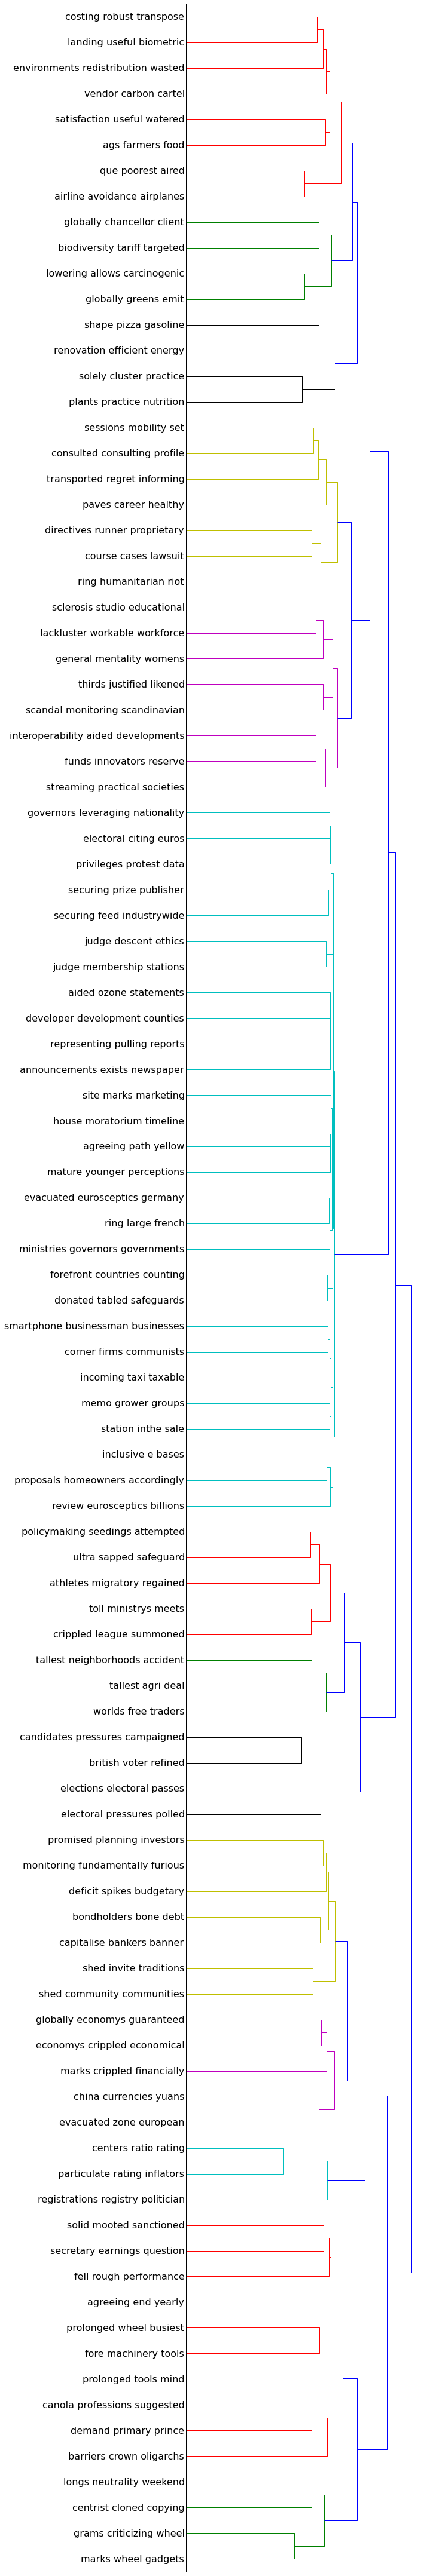

In [35]:
linkage_matrix = ward(topic_dist) # define the linkage_matrix using ward clustering pre-computed distances

fig, ax = plt.subplots(figsize=(10, 60)) # set size
ax = dendrogram(linkage_matrix, orientation="left", labels=np.array(nmf100_labels), leaf_font_size=16);

plt.tick_params(\
    axis= 'x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off')

plt.tight_layout()

# uncomment below to save figure
plt.savefig('topic_heirarchy.png', dpi=200) #save figure as ward_clusters

In [ ]:
nmf = joblib.load('nmf.pkl')

160
100
40
300
10
140
80
200
50
20
30
120
180
250
60
350


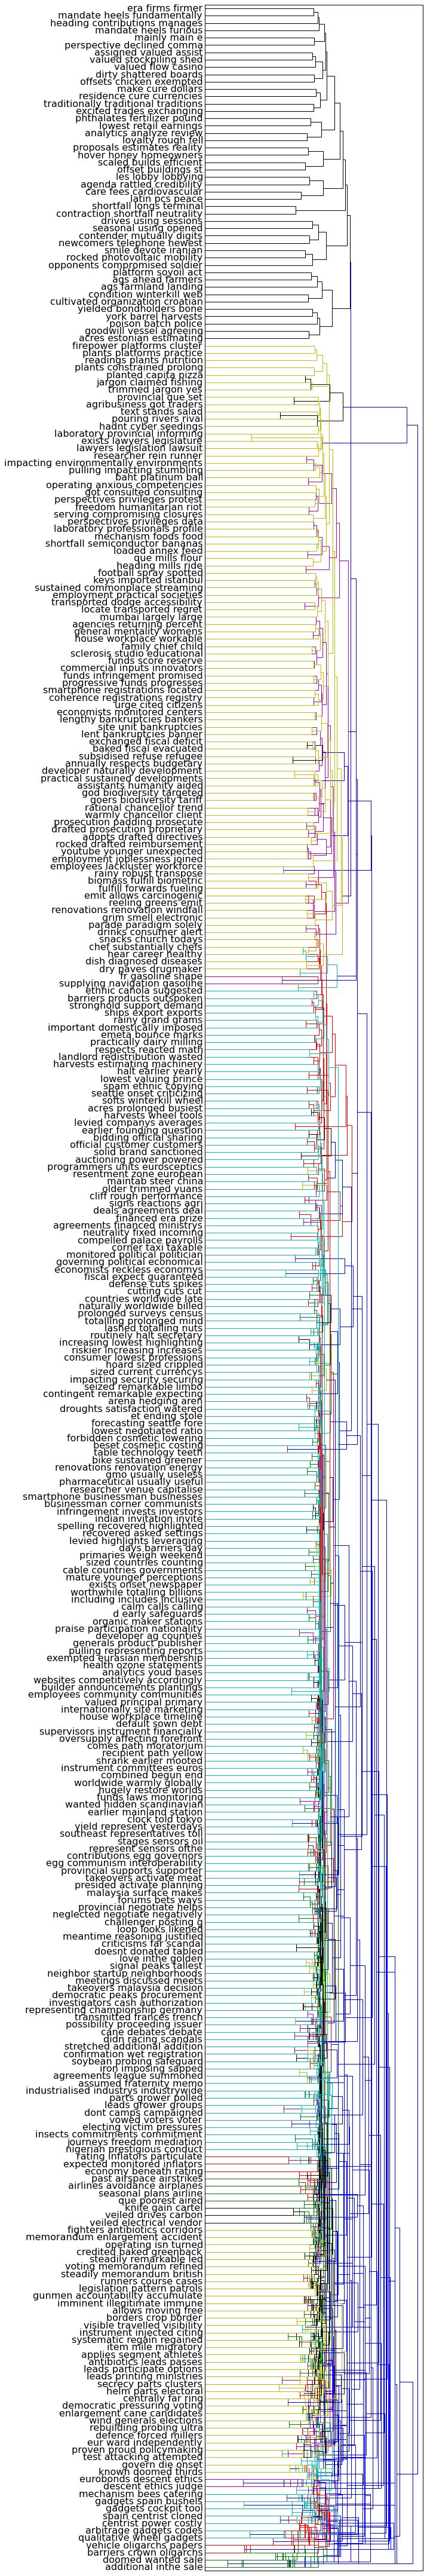

In [43]:
fig, ax = plt.subplots(figsize=(10, 60)) # set size

for k in nmf.keys():
    print k
    nmfn_topics=list()
    nmfn_labels=list()

    nmfn_user_topics = nmf[k].components_ * tf.transpose()

    for topic_idx, topic in enumerate(nmf[k].components_):
        #print("Topic #%d: " % topic_idx + " ".join([tf_feature_names[i] for i in topic.argsort()[:-51:-1]]))
        nmfn_topics.append("Topic #%d: " % topic_idx + " ".join([tf_feature_names[i] for i in topic.argsort()[:-11:-1]]))
        nmfn_labels.append(" ".join([tf_feature_names[x] for x in topic.argsort()[-3:]]))
    
    topic_dist = np.matrix(1 - cosine_similarity(nmf[k].components_))
    topic_min_dist = np.where(topic_dist == topic_dist[np.where(topic_dist > 0.01)].min())[0]
 

    linkage_matrix = ward(topic_dist) # define the linkage_matrix using ward clustering pre-computed distances

    ax = dendrogram(linkage_matrix, orientation="left", labels=np.array(nmfn_labels), leaf_font_size=16);

    plt.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')

    plt.tight_layout()

    # uncomment below to save figure
    plt.savefig('topic_heirarchy' + str(k) + '.png', dpi=200) #save figure as ward_clusters